# Hello, Namaste, konichiwa 👋, 🙏, 🙇

Here we generate anime images from real photos in styles of several anime creators like Makoto Shinkai, Hayao Miyazaki etc. If you are an anime fan boy or anime fan girl and also a fan of Machine Learning then you are at correct place.
We here use CycleGAN with identity loss for training and Generating images

# DATA RETRIVAL (run only once !!!)

```python
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"
! cp /content/drive/MyDrive/kaggle/kaggle.json /root/.kaggle/
import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files('dysonsphere90/animegan',path = "AnimeGAN",unzip=True)
```
cp: cannot create regular file '/root/.kaggle/': Not a directory

Dataset URL: https://www.kaggle.com/datasets/dysonsphere90/animegan


```python
from collections import defaultdict
import os
data_file = defaultdict(lambda: defaultdict(list))
len(os.listdir("/kaggle/input/animegan/Hayao/style"))
data_file['train']['Hayao'] = [f'/kaggle/input/animegan/Hayao/style{pic}' for pic in os.listdir("/kaggle/input/animegan/Hayao/style")]
data_file['train']['Paprika'] = [f'/kaggle/input/animegan/Paprika/style{pic}' for pic in os.listdir("/kaggle/input/animegan/Paprika/style")]
data_file['train']['Shinkai'] = [f'/kaggle/input/animegan/Shinkai/style{pic}' for pic in os.listdir("/kaggle/input/animegan/Shinkai/style")]
data_file['train']['SummerWar'] = [f'/kaggle/input/animegan/SummerWar/style/{pic}' for pic in os.listdir("/kaggle/input/animegan/SummerWar/style")]
data_file['train']['train_photo'] = [f'/kaggle/input/animegan/train_photo/{pic}' for pic in os.listdir("/kaggle/input/animegan/train_photo")]
data_file['val']['photo'] = [f'/kaggle/input/animegan/test/label_map/{pic}' for pic in os.listdir("/kaggle/input/animegan/test/label_map")]
data_file['val']['anime'] = [f'/kaggle/input/animegan/test/test_photo/{pic}' for pic in os.listdir("/kaggle/input/animegan/test/test_photo")]
print("Hayao Miyazaki's work: ",len(data_file['train']['Hayao']))
print("from Paprika 2007: ",len(data_file['train']['Paprika']))
print("Makoto Shinkai's work: ",len(data_file['train']['Shinkai']))
print("from SummerWars: ",len(data_file['train']['SummerWar']))
print("photo landscapes: ",len(data_file['train']['train_photo']))
print("validation photo: ",len(data_file['val']['photo']))
print("validation anime: ",len(data_file['val']['anime']))
```
Hayao Miyazaki's work:  1792\
from Paprika 2007:  1553\
Makoto Shinkai's work:  1650\
from SummerWars:  1357\
photo landscapes:  6656\
validation photo:  790\
validation anime:  791

```python
import json
os.mkdir('AnimeGAN')
json.dump(data_file,open("AnimeGAN/data_config.json","w"))
```

In [1]:
from collections import defaultdict
import os
import json
data_file = defaultdict(lambda: defaultdict(list))
len(os.listdir("/kaggle/input/animegan/Hayao/style"))
data_file['train']['Hayao'] = [f'/kaggle/input/animegan/Hayao/style/{pic}' for pic in os.listdir("/kaggle/input/animegan/Hayao/style")]
data_file['train']['Paprika'] = [f'/kaggle/input/animegan/Paprika/style/{pic}' for pic in os.listdir("/kaggle/input/animegan/Paprika/style")]
data_file['train']['Shinkai'] = [f'/kaggle/input/animegan/Shinkai/style/{pic}' for pic in os.listdir("/kaggle/input/animegan/Shinkai/style")]
data_file['train']['SummerWar'] = [f'/kaggle/input/animegan/SummerWar/style/{pic}' for pic in os.listdir("/kaggle/input/animegan/SummerWar/style")]
data_file['train']['train_photo'] = [f'/kaggle/input/animegan/train_photo/{pic}' for pic in os.listdir("/kaggle/input/animegan/train_photo")]
data_file['val']['photo'] = [f'/kaggle/input/animegan/test/label_map/{pic}' for pic in os.listdir("/kaggle/input/animegan/test/label_map")]
data_file['val']['anime'] = [f'/kaggle/input/animegan/test/test_photo/{pic}' for pic in os.listdir("/kaggle/input/animegan/test/test_photo")]
print("Hayao Miyazaki's work: ",len(data_file['train']['Hayao']))
print("from Paprika 2007: ",len(data_file['train']['Paprika']))
print("Makoto Shinkai's work: ",len(data_file['train']['Shinkai']))
print("from SummerWars: ",len(data_file['train']['SummerWar']))
print("photo landscapes: ",len(data_file['train']['train_photo']))
print("validation photo: ",len(data_file['val']['photo']))
print("validation anime: ",len(data_file['val']['anime']))
if not os.path.isdir('AnimeGAN'): os.mkdir('AnimeGAN')
json.dump(data_file,open("AnimeGAN/data_config.json","w"))

Hayao Miyazaki's work:  1792
from Paprika 2007:  1553
Makoto Shinkai's work:  1650
from SummerWars:  1357
photo landscapes:  6656
validation photo:  790
validation anime:  791


In [2]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

# ARCHITECTURE

### Pᴀᴛᴄʜ GAN ᴀs Dɪsᴄʀɪᴍɪɴᴀᴛᴏʀ

In [3]:
import torch
import torch.nn as nn

class DBlock(nn.Module):
    def __init__(self,in_channels,out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=True,
                padding_mode='reflect'
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self,x): return self.conv(x)
class Discriminator(nn.Module):
    def __init__(self,in_channels, features = [64,128,256,512]):
        super().__init__()
        layers = list()
        init_channels = in_channels
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                DBlock(
                    in_channels=in_channels,
                    out_channels=feature,
                    stride = 1 if feature==features[-1] else 2
                )
            )
            in_channels = feature
        self.discriminator = nn.Sequential(
            #initial
            nn.Sequential(
                nn.Conv2d(
                    in_channels=init_channels,
                    out_channels=features[0],
                    kernel_size=4,
                    stride=2,
                    padding=1,
                    padding_mode='reflect'
                ),
                nn.LeakyReLU(0.2)
            ),
            #intermediate
            nn.Sequential(*layers),
            #final
            nn.Conv2d(
                in_channels=in_channels,
                out_channels = 1,
                kernel_size=4,
                stride = 1,
                padding=1,
                padding_mode='reflect'
            )
        )
    def forward(self,x):
        return self.discriminator(x)

def test():
    x = torch.randn((1,3,256,256))
    model = Discriminator(in_channels = 3)
    print(model(x).shape)
test()


torch.Size([1, 1, 30, 30])


VGG As Gᴇɴᴇʀᴀᴛᴏʀ

In [4]:
import torch
import torch.nn as nn

class GBlock(nn.Module):
    def __init__(self,in_channels, out_channels, down = True, use_act = True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, padding_mode='reflect', **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )
    def forward(self,x): return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self,channels):
        super().__init__()
        self.block = nn.Sequential(
            GBlock(in_channels=channels,out_channels=channels,use_act=True,kernel_size = 3,padding=1),
            GBlock(in_channels=channels,out_channels=channels,use_act=False,kernel_size = 3, padding=1),
        )
    def forward(self,x): return x+self.block(x)

class Generator(nn.Module):
    def __init__(self,in_channels,num_residuals=9):
        super().__init__()
        self.generator = nn.Sequential(
            nn.Conv2d(in_channels,64,kernel_size=7,stride=1, padding=3, padding_mode='reflect'),
            nn.ReLU(inplace=True),
            GBlock(64,128,down=True, use_act = True,kernel_size = 3,stride = 2,padding = 1),
            GBlock(128,256,down=True, use_act = True,kernel_size = 3,stride = 2,padding = 1),
            *([ResidualBlock(256)]*num_residuals),
            GBlock(256,128,down=False, kernel_size = 3, stride = 2, padding=1,output_padding=1),
            GBlock(128,64,down=False, kernel_size = 3, stride = 2, padding=1,output_padding=1),
            nn.Conv2d(64,3,7,1,3,padding_mode="reflect")
        )
    def forward(self,x): return self.generator(x)

def test():
    x = torch.randn((2,3,256,256))
    gen = Generator(3)
    print(gen(x).shape)
test()

torch.Size([2, 3, 256, 256])


# CONFIGURATIONS

In [5]:
from torchvision import transforms
import os
from typing import Callable
import torch
if not os.path.isdir("AnimeGAN/checkpoints"):
    os.mkdir("AnimeGAN/checkpoints")
if not os.path.isdir("AnimeGAN/gen_photo"):
    os.mkdir("AnimeGAN/gen_photo")
if not os.path.isdir("AnimeGAN/gen_anime"):
    os.mkdir("AnimeGAN/gen_anime")

class Config:
    LEARNING_RATE:float = 0.0002
    BETA_1:float = 0.5
    BETA_2:float = 0.999
    LAMBDA_CYCLE:int = 10
    LAMBDA_IDENTITY:int = 5
    NUM_EPOCHS:int = 20
    DATA_CONFIG:str = "AnimeGAN/data_config.json"
    BATCH_SIZE:int = 1
    NUM_WORKERS:int = 4
    SAVE_MODEL:bool = True
    LOAD_MODEL:bool = False
    CHECKPOINT_GEN_ANIMATION:Callable[str, str] = lambda self,creator:f'AnimeGAN/checkpoints/{creator}/gen_animation.pth'
    CHECKPOINT_DIS_ANIMATION:Callable[str, str] = lambda self,creator:f'AnimeGAN/checkpoints/{creator}/dis_animation.pth'
    CHECKPOINT_GEN_PHOTO:Callable[str, str] = lambda self,creator:f'AnimeGAN/checkpoints/{creator}/gen_photo.pth'
    CHECKPOINT_DIS_PHOTO:Callable[str, str] = lambda self,creator:f'AnimeGAN/checkpoints/{creator}/dis_photo.pth'
    DEVICE:str = "cuda" if torch.cuda.is_available() else "cpu"
    ANIME_SAVED_IMAGES:str = "AnimeGAN/gen_anime"
    PHOTO_SAVED_IMAGES:str = "AnimeGAN/gen_photo"
    preprocess:transforms.transforms.Compose = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

# UTILITIES

In [12]:
import torch
# from config import Config
config = Config()
class Utils:
    def save(self,model,optimizer,file_name)->None:
        checkpoint = {
            "model":model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        torch.save(model.state_dict(),file_name)
    def load(self,model,optimizer,file_name)->None:
        checkpoint = torch.load(file_name, map_location = config.DEVICE)
        print('__loading checkpoint for model__')
        model.load_state_dict(checkpoint['model'])
        print('__loading checkpoint for optimizer__')
        optimizer.load_state_dict(checkpoint['optimizer'])
        for param_group  in optimizer.param_groups:
            param_group['lr'] = config.LEARNING_RATE
        print('__finished loading checkpoint__')


# DATASET

In [7]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import json
import os
# from config import Config
config = Config()
data_config = json.load(open(config.DATA_CONFIG))
class PhotoToAnimeDataset(Dataset):
    def __init__(self,creator:str = None, train:bool = True,transform:bool = True)->None:
        if train:
            if creator not in {'Hayao','Paprika','Shinkai','SummerWar'}:
                raise ValueError("creator must be one of 'Hayao','Paprika','Shinkai','SummerWar'")
            self.photo_list = data_config['train']['train_photo']
            self.anime_list = data_config['train'][creator]

        else:
            self.photo_list = data_config['val']['photo']
            self.anime_list = data_config['val']['anime']
        self.transform = transform
    def __len__(self)->int:
        return max(len(self.photo_list),len(self.anime_list))
    def __getitem__(self,idx)->tuple:
        photo_img = Image.open(self.photo_list[idx%len(self.photo_list)]).convert('RGB')
        anime_img = Image.open(self.anime_list[idx%len(self.anime_list)]).convert('RGB')
        if self.transform:
            photo_img = config.preprocess(photo_img)
            anime_img = config.preprocess(anime_img)
        return photo_img,anime_img

# THE TRAINING ALGORITHM
Taken from [Unpaired Image-to-Image Translation
using Cycle-Consistent Adversarial Networks by Jun Yan et.al.](https://arxiv.org/pdf/1703.10593)
$L_{GAN}(G, D_Y , X, Y ) = E_{y∼pdata(y)} [\log (D_Y (y))] + E_{x∼pdata(x)} [\log(1 − D_Y (G(x))]$

$L_{cyc}(G, F) = E_{x∼pdata(x)} [||F(G(x)) − x||_1] + E_{y∼pdata(y)} [||G(F(y)) − y||_1]$

$L(G, F, D_X, D_Y ) = L_{GAN}(G, D_Y , X, Y ) + L_{GAN}(F, D_X, Y, X) + λL_{cyc}(G, F)$

$L_{GAN}$ , we replace the negative log likelihood objective by a least-squares loss. This loss is
more stable during training and generates higher quality results. In particular, for a GAN loss $L_{GAN}(G, D, X, Y )$, we train the G to minimize $$E_{x∼p_{data}(x)}[(D(G(x)) − 1)^2]$$ and train the D to minimize $$E_{y∼p_{data}(y)} [(D(y) − 1)^2] +E_{x∼{p_{data}(x)}}[D(G(x))^2]$$



In [8]:
import torch
# from utils import Utils
# from config import Config
utils = Utils()
config = Config()
from tqdm import tqdm
import torch.nn as nn
from torchvision.utils import save_image
import matplotlib.pyplot as plt
class Trainer:
    def train_epoch(
            self,config = Config(),
            disc_anime = None,
            gen_anime = None,
            disc_photo = None,
            gen_photo = None,
            trainloader = None,
            valloader = None,
            opt_disc = None,
            opt_gen = None,
            l1_loss = None,
            bce_loss = None,
            d_scaler = torch.cuda.amp.GradScaler(),
            g_scaler = torch.cuda.amp.GradScaler(),
        ):
        discriminator_loss_epoch = 0
        generator_loss_epoch = 0

        loader = tqdm(trainloader,colour='blue')
        for idx,(photo_img,anime_img) in enumerate(loader):
            photo_img = photo_img.to(config.DEVICE)
            anime_img = anime_img.to(config.DEVICE)

            #train discriminator
            with torch.cuda.amp.autocast():
                # loss for generating anime from photo
                fake_anime = gen_anime(photo_img)
                disc_fake_anime,disc_real_anime = disc_anime(fake_anime.detach()),disc_anime(anime_img)
                disc_anime_loss_fake = bce_loss(disc_fake_anime,torch.zeros_like(disc_fake_anime))
                disc_anime_loss_real = bce_loss(disc_real_anime,torch.ones_like(disc_real_anime))
                disc_anime_loss = disc_anime_loss_fake + disc_anime_loss_real

                # loss for generating photo from anime
                fake_photo = gen_photo(anime_img)
                disc_fake_photo, disc_real_photo = disc_photo(fake_photo.detach()),disc_photo(photo_img)
                disc_photo_loss_fake = bce_loss(disc_fake_photo,torch.zeros_like(disc_fake_photo))
                disc_photo_loss_real = bce_loss(disc_real_photo,torch.ones_like(disc_real_photo))
                disc_photo_loss = disc_photo_loss_fake + disc_photo_loss_real
                disc_loss = (disc_anime_loss + disc_photo_loss)/2
                discriminator_loss_epoch += disc_loss.item()
            opt_disc.zero_grad()
            d_scaler.scale(disc_loss).backward(retain_graph = True)
            d_scaler.step(opt_disc)
            d_scaler.update()

            # train generator
            with torch.cuda.amp.autocast():
                # generator loss for minimization of log(1-D(G(x)))
                disc_gen_fake_anime,disc_gen_fake_photo = disc_anime(fake_anime),disc_anime(fake_photo)
                gen_loss_anime = bce_loss(disc_gen_fake_anime,torch.ones_like(disc_gen_fake_anime))
                gen_loss_photo = bce_loss(disc_gen_fake_photo,torch.ones_like(disc_gen_fake_photo))

                # cycle loss
                cycle_anime_loss = l1_loss(anime_img,gen_anime(fake_photo))
                cycle_photo_loss = l1_loss(photo_img,gen_photo(fake_anime))

                # identity loss
                identity_anime_loss = l1_loss(anime_img,gen_anime(anime_img))
                identity_photo_loss = l1_loss(photo_img,gen_photo(photo_img))

                gen_loss = gen_loss_anime + gen_loss_photo + (cycle_anime_loss + cycle_photo_loss)*config.LAMBDA_CYCLE + (identity_anime_loss + identity_photo_loss)*config.LAMBDA_IDENTITY
                generator_loss_epoch += gen_loss.item()
            opt_gen.zero_grad()
            g_scaler.scale(gen_loss).backward()
            g_scaler.step(opt_gen)
            g_scaler.update()
            if not idx%200:
                save_image(fake_anime*0.5+0.5,f"{config.ANIME_SAVED_IMAGES}/{idx}.png")
                save_image(fake_photo*0.5+0.5,f"{config.PHOTO_SAVED_IMAGES}/{idx}.png")
            loader.set_postfix(
                disc_loss = f"{disc_loss.item():.4f}",
                gen_loss = f"{gen_loss.item():.4f}"
            )
        return discriminator_loss_epoch/len(trainloader),generator_loss_epoch/len(trainloader)


    def train(self,creator:str=None):
        disc_anime,disc_photo = Discriminator(in_channels=3).to(config.DEVICE),Discriminator(in_channels=3).to(config.DEVICE)
        gen_anime,gen_photo = Generator(in_channels=3).to(config.DEVICE),Generator(in_channels=3).to(config.DEVICE)
        opt_disc = torch.optim.Adam(
            list(disc_anime.parameters()) + list(disc_photo.parameters()),
            lr = config.LEARNING_RATE,
            betas = (config.BETA_1,config.BETA_2)
        )
        opt_gen = torch.optim.Adam(
            list(gen_anime.parameters()) + list(gen_photo.parameters()),
            lr = config.LEARNING_RATE,
            betas = (config.BETA_1,config.BETA_2)
        )
        l1_loss = nn.L1Loss()
        bce_loss = nn.BCEWithLogitsLoss()
        if config.LOAD_MODEL:
            utils.load(
                disc_anime,
                opt_disc,
                config.CHECKPOINT_DIS_ANIMATION(creator)
            )
            utils.load(
                disc_photo,
                opt_disc,
                config.CHECKPOINT_DIS_PHOTO(creator)
            )
            utils.load(
                gen_anime,
                opt_gen,
                config.CHECKPOINT_GEN_ANIMATION(creator)
            )
            utils.load(
                gen_photo,
                opt_gen,
                config.CHECKPOINT_GEN_PHOTO(creator)
            )
        try:
            trainset = PhotoToAnimeDataset(creator = creator,transform=True)
            trainloader = torch.utils.data.DataLoader(
                trainset,
                batch_size = config.BATCH_SIZE,
                shuffle = True,
                num_workers = config.NUM_WORKERS
            )
        except ValueError as e:
            print(e)
            return
        valset = PhotoToAnimeDataset(train=False,transform=True)
        valloader = torch.utils.data.DataLoader(
            valset,
            batch_size = config.BATCH_SIZE,
            shuffle = False,
            num_workers = config.NUM_WORKERS
        )
        generator_loss = list()
        discriminator_loss = list()
        print('__Training__')
        for epoch in range(config.NUM_EPOCHS):
            print(f"Epoch {epoch+1}/{config.NUM_EPOCHS}")
            gen_loss,disc_loss = self.train_epoch(
                config = config,
                disc_anime = disc_anime,
                gen_anime = gen_anime,
                disc_photo = disc_photo,
                gen_photo = gen_photo,
                trainloader = trainloader,
                valloader = valloader,
                opt_disc = opt_disc,
                opt_gen = opt_gen,
                l1_loss = l1_loss,
                bce_loss = bce_loss
            )
            generator_loss.append(gen_loss)
            discriminator_loss.append(disc_loss)
            if config.SAVE_MODEL:
                if not os.path.isdir(f'AnimeGAN/checkpoints/{creator}'):
                    os.mkdir(f'AnimeGAN/checkpoints/{creator}')
                utils.save(
                    disc_anime,
                    opt_disc,
                    config.CHECKPOINT_DIS_ANIMATION(creator)
                )
                utils.save(
                    disc_photo,
                    opt_disc,
                    config.CHECKPOINT_DIS_PHOTO(creator)
                )
                utils.save(
                    gen_anime,
                    opt_gen,
                    config.CHECKPOINT_GEN_ANIMATION(creator)
                )
                utils.save(
                    gen_photo,
                    opt_gen,
                    config.CHECKPOINT_GEN_PHOTO(creator)
                )
        print("__Training Complete__")
        # plotting
        print("__plotting loss curves__")
        plt.figure(figsize=(30,30))
        plt.plot(generator_loss,color="red")
        plt.plot(discriminator_loss,color='blue')
        plt.legend(['gen_loss','disc_loss'])
        plt.title('LOSS vs EPOCH',fontdict={'fontsize':10})
        plt.xlabel('EPOCH')
        plt.ylabel('LOSS')
        plt.xticks(range(0, config.NUM_EPOCHS+1 , 1),fontsize=10)
        plt.yticks(fontsize=10)
        plt.show()



__Training__
Epoch 1/20


100%|██████████| 6656/6656 [24:20<00:00,  4.56it/s, disc_loss=0.4392, gen_loss=5.9664] 


Epoch 2/20


100%|██████████| 6656/6656 [24:22<00:00,  4.55it/s, disc_loss=0.7366, gen_loss=4.5194] 


Epoch 3/20


100%|██████████| 6656/6656 [24:22<00:00,  4.55it/s, disc_loss=0.8413, gen_loss=4.8389] 


Epoch 4/20


 41%|████      | 2739/6656 [10:02<14:19,  4.55it/s, disc_loss=0.7378, gen_loss=4.8462] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 6656/6656 [24:22<00:00,  4.55it/s, disc_loss=0.4053, gen_loss=4.5480] 


Epoch 5/20


100%|██████████| 6656/6656 [24:20<00:00,  4.56it/s, disc_loss=0.5561, gen_loss=4.7949] 


Epoch 6/20


100%|██████████| 6656/6656 [24:21<00:00,  4.55it/s, disc_loss=0.3044, gen_loss=4.4297] 


Epoch 7/20


100%|██████████| 6656/6656 [24:21<00:00,  4.55it/s, disc_loss=0.3559, gen_loss=4.8484]


Epoch 8/20


 27%|██▋       | 1797/6656 [06:34<17:48,  4.55it/s, disc_loss=0.2528, gen_loss=5.1595]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 67%|██████▋   | 4488/6656 [16:23<07:55,  4.56it/s, disc_loss=0.7175, gen_loss=5.6107]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 6656/6656 [24:19<00:00,  4.56it/s, disc_loss=0.3725, gen_loss=5.1296]


Epoch 9/20


100%|██████████| 6656/6656 [24:20<00:00,  4.56it/s, disc_loss=0.3341, gen_loss=4.6746]


Epoch 12/20


100%|██████████| 6656/6656 [24:18<00:00,  4.56it/s, disc_loss=0.5545, gen_loss=4.7069]


Epoch 13/20


100%|██████████| 6656/6656 [24:21<00:00,  4.55it/s, disc_loss=0.4492, gen_loss=4.3007]


Epoch 14/20


100%|██████████| 6656/6656 [24:20<00:00,  4.56it/s, disc_loss=0.3849, gen_loss=5.4292]


Epoch 15/20


100%|██████████| 6656/6656 [24:20<00:00,  4.56it/s, disc_loss=0.3391, gen_loss=4.7304]


Epoch 16/20


100%|██████████| 6656/6656 [24:18<00:00,  4.56it/s, disc_loss=0.3080, gen_loss=3.9127]


Epoch 17/20


100%|██████████| 6656/6656 [24:17<00:00,  4.57it/s, disc_loss=0.3172, gen_loss=4.9523]


Epoch 18/20


100%|██████████| 6656/6656 [24:20<00:00,  4.56it/s, disc_loss=0.1765, gen_loss=4.2858]


Epoch 19/20


100%|██████████| 6656/6656 [24:19<00:00,  4.56it/s, disc_loss=0.5907, gen_loss=5.0284]


Epoch 20/20


100%|██████████| 6656/6656 [24:19<00:00,  4.56it/s, disc_loss=0.6180, gen_loss=4.0689]


__Training Complete__
__plotting loss curves__


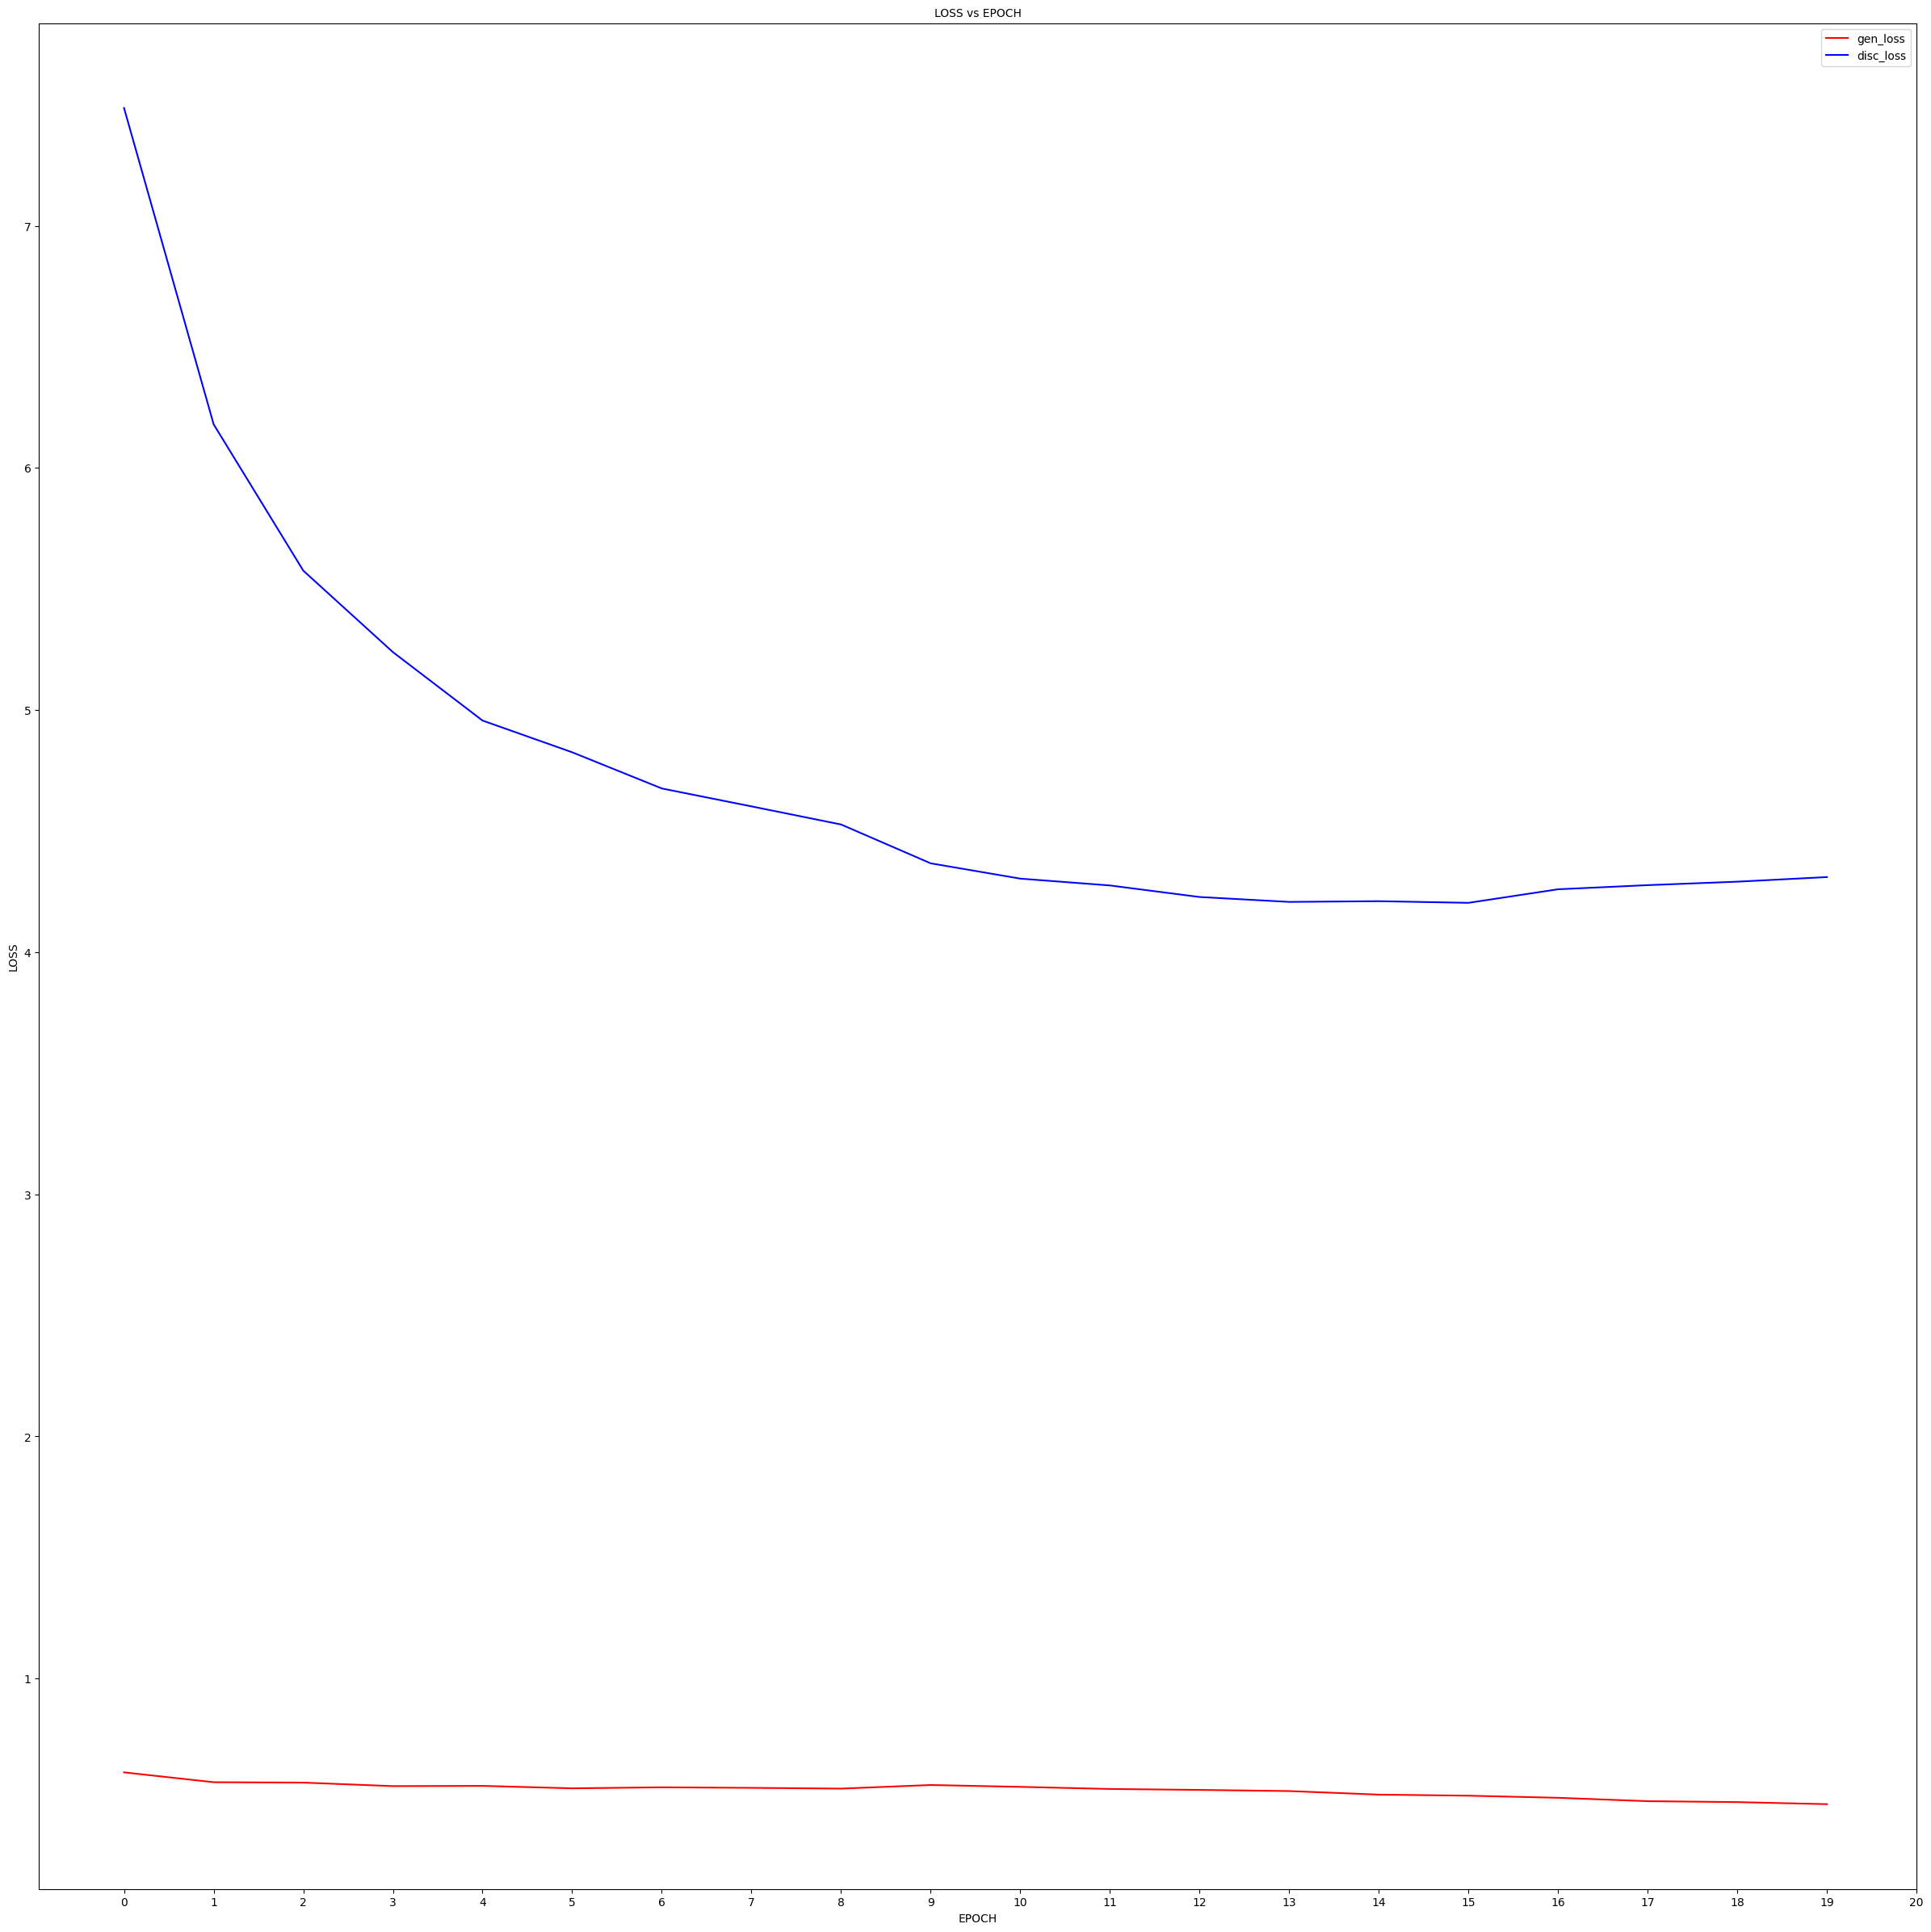

In [9]:
trainer = Trainer()
trainer.train(creator='Hayao')

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


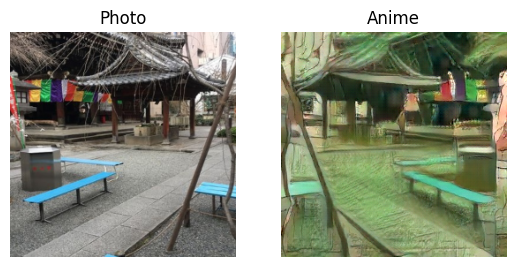

In [32]:
generator_anime = Generator(in_channels=3)
generator_photo = Generator(in_channels = 3)
utils = Utils()

opt_gen = torch.optim.Adam(
            list(generator_anime.parameters()) + list(generator_photo.parameters()),
            lr = config.LEARNING_RATE,
            betas = (config.BETA_1,config.BETA_2)
        )

checkpoint = torch.load(config.CHECKPOINT_GEN_ANIMATION("Hayao"), map_location = config.DEVICE)
type(checkpoint)
checkpoint.keys()
generator_anime.load_state_dict(checkpoint)
photo = config.preprocess(Image.open('/kaggle/input/animegan/test/real/105.jpg').convert('RGB'))
anime = (generator_anime(photo)*0.5)+0.5
import matplotlib.pyplot as plt
with torch.no_grad():
    fig, axs = plt.subplots(1, 2)

      # Plot photo on the first subplot
    axs[0].imshow((config.preprocess(Image.open('/kaggle/input/animegan/test/real/105.jpg').convert('RGB')) * 0.5 + 0.5).permute(1,2,0))
    axs[0].set_title('Photo')
    axs[0].axis('off')  # Hide x and y axis labels for cleaner visualization

  # Plot anime on the second subplot
    axs[1].imshow(anime.permute(1, 2, 0))
    axs[1].set_title('Anime')
    axs[1].axis('off')
plt.show()